#Deep Learning based Temporal Causal Discovery from Non-stationary Non-linear Time Series Data (FMRI Dataset)


This notebook contains the proposed model. Here we have developed the proposed Causal Conv2D layer and the optimization function.

The functions to visualize the predicted causal graph are available after the model training codes. The predicted graph is compared with ground truth using an adjacency matrix (array).   

In this notebook, we applied the proposed model to the synthetic dataset-3 to generate a full causal graph and summary graph.

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
data = pd.read_csv('/content/FMRI-Data.csv')
#data

In [ ]:
true_graph = np.zeros((5,5))
true_graph[0,1]=1
true_graph[0,4]=1
true_graph[1,2]=1
true_graph[2,3]=1
true_graph[3,4]=1
true_graph

array([[0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]])

In [ ]:
import scipy.io

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, (m*m)/(sd*sd))



In [ ]:
data_np = data.to_numpy()

In [ ]:
snr1 = signaltonoise(data_np[:,0])
snr2 = signaltonoise(data_np[:,1])
snr3 = signaltonoise(data_np[:,2])
snr4 = signaltonoise(data_np[:,3])

In [ ]:
snr1, snr2, snr3, snr4

(array(1.23747245e-34),
 array(2.25060508e-35),
 array(4.1178919e-37),
 array(4.47097224e-35))

In [ ]:
!pip install cdt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.1/921.1 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7394 sha256=5452f74f463ca04ba912e6faa06c44bce754e9493b534b7a29d37b2e4d509fb8
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29255 sha256=44927526fd8942a6ee91a98c797fd7fc1caacb69f9b1d60280b5ccec4e6dc701
  Stored in directory: /root/.cache/pip/wheels/dd/67/40/683074a684607162bd0e34dcf7ccdfcab5861c3b2a83286f3a
Successfully built GPUtil skrebate


In [ ]:
import cdt

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


#Data Pre-processing

In [ ]:
syn_data_np = data.to_numpy()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler(feature_range=(0, 1))

syn_data_np_nor = scaler_X.fit_transform(syn_data_np)

In [ ]:
syn_data_np.shape, syn_data_np_nor.shape

In [ ]:
syn_data_np = syn_data_np_nor

In [ ]:
syn_data_np_T= syn_data_np.T

In [ ]:
syn_data_pro = np.zeros((syn_data_np.shape[0]-2,5,3))
for i in range(0, (syn_data_np.shape[0]-2)):
  syn_data_pro[i,:,:]= syn_data_np_T[0:5, i:i+3]


In [ ]:
syn_data_pro[0,:,:], syn_data_np_T[0:5,0:3]

(array([[0.37349215, 0.4442903 , 0.40493454],
        [0.41572759, 0.46380577, 0.44884027],
        [0.50517201, 0.38353911, 0.50146599],
        [0.61441643, 0.69902813, 0.68356306],
        [0.49689653, 0.61686047, 0.56051063]]),
 array([[0.37349215, 0.4442903 , 0.40493454],
        [0.41572759, 0.46380577, 0.44884027],
        [0.50517201, 0.38353911, 0.50146599],
        [0.61441643, 0.69902813, 0.68356306],
        [0.49689653, 0.61686047, 0.56051063]]))

In [ ]:
syn_data_2d = np.expand_dims(syn_data_pro, axis =-1)
syn_data_2d.shape

(2398, 5, 3, 1)

In [ ]:
syn_data_np_4 = syn_data_np[:,0:5]
syn_data_np_4.shape

(2400, 5)

In [ ]:
data.columns

Index(['S1', 'S2', 'S3', 'S4', 'S5'], dtype='object')

In [ ]:
syn_data_4_df =pd.DataFrame(data = syn_data_np_4,
                  columns = ['S1', 'S2', 'S3', 'S4', 'S5'])

In [ ]:
syn_data_4_df.iloc[:5,:]

,S1,S2,S3,S4,S5
0,0.373492,0.415728,0.505172,0.614416,0.496897
1,0.444290,0.463806,0.383539,0.699028,0.616860
2,0.404935,0.448840,0.501466,0.683563,0.560511
3,0.698631,0.343690,0.488534,0.716959,0.443769
4,0.753538,0.503854,0.637850,0.659428,0.501231


In [ ]:
syn_data_np.shape, syn_data_2d.shape

((2400, 5), (2398, 5, 3, 1))

In [ ]:
data_y_syn = syn_data_np[2:,:]
data_y_syn.shape

(2398, 5)

# Proposed Model

In [ ]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, AveragePooling2D, LSTM, Activation, ConvLSTM2D, TimeDistributed, Input, Reshape
from keras.layers import UpSampling1D, Conv2DTranspose, UpSampling2D, Conv1D, AveragePooling1D, LeakyReLU
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
import keras.backend as K
import tensorflow as tf
from keras.layers import concatenate
from keras.regularizers import l1, l2
from time import time

keras.utils.set_random_seed(1001)

In [ ]:
class CausalConv2D(tf.keras.layers.Layer):
    def __init__(self, num_outputs, counter, *args, **kwargs):
        super(CausalConv2D, self).__init__()
        self.conv2d = tf.keras.layers.Conv2D(*args, **kwargs)
        self.num_outputs = num_outputs
        self.counter = counter

    def build(self, input_shape):
        self.W=self.add_weight(name='kernel',
                           shape=(input_shape[1], input_shape[2],input_shape[3], 1),
                           initializer = tf.keras.initializers.glorot_uniform(seed=8),
                           trainable=True)
        self.mask = np.ones(shape=self.W.shape)
        #print(self.W)
        self.mask[self.counter,(input_shape[2]-1),...] = 0.0

    def get_weights(self):
        return super().get_weights()

    def call(self, inputs):
        self.W.assign(tf.math.multiply(self.W, self.mask))
        #self.conv2d._convolution_op = functools.partial(self.masked_convolution_op, mask=mask)
        #return self.conv2d.call(x)
        return self.conv2d.convolution_op(inputs, self.W)

In [ ]:
# 2D
def get_model_2d(input_dims):
    input_batch = Input(shape = input_dims)

    conv_model = Sequential()
    conv_model = Conv2D(filters=4, kernel_size=1, strides=(1,1), padding='valid', activation="linear", name='conv1')(input_batch)
    #conv_model = AveragePooling2D(pool_size=(1,1), strides=None, padding='valid', name='pool1')(conv_model) activation=LeakyReLU(0.05)
    conv_model = tf.math.reduce_mean(conv_model, axis=-1)
    conv_model = Reshape((5, 3, 1))(conv_model)
    #conv_model = Flatten()(conv_model )
    pooled_outputs = []
    for i in range(0, 5):
      #layer = CausalConv2D(num_outputs=1, counter=i, name="parr"+str(i))(conv_model) # , kernel_regularizer = l1(0.2)
      layer = CausalConv2D(filters=1, kernel_size=(5,3), num_outputs=1, counter=i, padding='valid', activation="tanh",)(conv_model)
      #den1 = layer(tf.ones([481, 30]))
      #conv = Conv2D(1, kernel_size=filter_sizes[i], padding='valid', activation='relu')(conv_model)
      pooled_outputs.append(layer)
    output = concatenate(pooled_outputs)
    output = Flatten()(output)

    model = Model(inputs=input_batch, outputs=output, name='cpred')

    return model

In [ ]:
# with gradient tape

class CausalNNModel(object):
    def __init__(self,
                 dims,
                 alpha=0.0,
                 rho = 1.0,
                 rho_max = 10e20,
                 h_tol = 1e-8,
                 init='glorot_uniform'):

        super(CausalNNModel, self).__init__()

        self.dims = dims
        self.n_stacks = len(self.dims) - 1
        self.alpha = alpha
        self.rho = rho
        self.h_p = np.Inf
        self.rho_max = rho_max
        self.h_tol = h_tol
        self.model_2d = get_model_2d(self.dims)
        print("====Model created=====")

        self.model = Model(inputs=self.model_2d.input, outputs=self.model_2d.output)


    def extract_features(self, x):
        return self.model_cnn.predict(x)

    def predict(self, x):  # predict cluster labels using the output of clustering layer
        q = self.model.predict(x, verbose=0)[1]
        return q.argmax(1)

    def custom_loss_function(self, y_true, y_pred):
      mse = keras.losses.mean_squared_error(y_true, y_pred)
      h_val = self.causal_loss_h()
      h_loss = 0.5 * self.rho * h_val * h_val + self.alpha * h_val
      lambda1 = 0.1
      adj_mat = self.get_mat()
      sparse_loss = lambda1 * tf.math.reduce_sum(tf.abs(adj_mat))
      #neg_weight = np.sum(adj_mat, where=adj_mat<0)
      #neg_loss = 0.5 * tf.abs(neg_weight)
      print('MSE Loss is: {}, h Loss is: {}, L1 loss: {}, Total Loss is: {}'.format(tf.reduce_mean(mse), h_loss, sparse_loss, tf.reduce_mean(mse)+h_loss))
      return mse + h_loss + sparse_loss #+ neg_loss

    def causal_loss_h(self):
      mat = self.get_mat()
      h_val = self.h_acy_1(mat[:, 10:])
      return h_val

    def get_mat(self):
      w1_2d_s = self.model.get_layer(index=-7).get_weights()
      w2_2d_s = self.model.get_layer(index=-6).get_weights()
      w3_2d_s = self.model.get_layer(index=-5).get_weights()
      w4_2d_s = self.model.get_layer(index=-4).get_weights()
      w5_2d_s = self.model.get_layer(index=-3).get_weights()
      arr1_2d_s = np.expand_dims(np.squeeze(np.array(w1_2d_s), axis=(0,3,4)).flatten('F'), axis=0)
      arr2_2d_s = np.expand_dims(np.squeeze(np.array(w2_2d_s), axis=(0,3,4)).flatten('F'), axis=0)
      arr3_2d_s = np.expand_dims(np.squeeze(np.array(w3_2d_s), axis=(0,3,4)).flatten('F'), axis=0)
      arr4_2d_s = np.expand_dims(np.squeeze(np.array(w4_2d_s), axis=(0,3,4)).flatten('F'), axis=0)
      arr5_2d_s = np.expand_dims(np.squeeze(np.array(w5_2d_s), axis=(0,3,4)).flatten('F'), axis=0)
      mat_2d_s = np.concatenate((arr1_2d_s, arr2_2d_s, arr3_2d_s, arr4_2d_s, arr5_2d_s))
      #print(mat_2d_s)
      return mat_2d_s

    def h_acy_1(self, A):
      n_var = A.shape[0]
      h = tf.linalg.trace(tf.linalg.expm(A * A)) - n_var
      return h


    def h_acy(self, A):
      '''Calculate the constraint of A ensure that it's a DAG'''
      #(Yu et al. 2019 DAG-GNN)
      # h(w) = tr[(I + kA*A)^n_variables] - n_variables
      n_var = A.shape[0]
      M = tf.eye(n_var, num_columns = n_var) + A/n_var
      E = M
      for _ in range(n_var - 2):
        E = tf.linalg.matmul(E, M)
      h = tf.math.reduce_sum(tf.transpose(E) * M) - n_var
      return h

    def compile(self, optimizer='adam'):
        self.model.compile(optimizer=optimizer, loss= self.custom_loss_function) # ['mse', self.causal_loss()])

    def fit(self, x, y=None, maxiter=100, batch_size=512, save_dir='./results/temp'):
        t1 = time()


        # Step 2: deep clustering
        # logging file
        import csv
        logfile = open(save_dir + '/causalnn_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter','loss'])
        logwriter.writeheader()
        train_loader = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)
        optimizer = tf.keras.optimizers.Adam(1e-2)
        w1_2d_s = self.model.get_layer(index=-6).get_weights()
        arr1_2d_s = np.expand_dims(np.squeeze(np.array(w1_2d_s), axis=(0,3,4)).flatten('F'), axis=0)


        for epoch in range(int(maxiter)):
          print('Epoch: {}', epoch)
          h_n = None
          for (x, y) in train_loader:
            #eval loss and compute gradients
            with tf.GradientTape() as tape:
              tape.watch(self.model.trainable_variables)
              #passing through neural network
              output = self.model(x)
              #calculate loss
              loss = self.custom_loss_function(y, output)
              gradients = tape.gradient(loss, self.model.trainable_variables)
              optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
              h_n = self.causal_loss_h()
              #print('New h_val is :', h_n)
              #if h_n > 0.25 * self.h_p:
              #  self.rho = self.rho*10
              #else:
              #  break

          if h_n > 0.25 * self.h_p:
                self.rho = self.rho*1.1
          self.h_p = h_n
          print('New h_val is :', h_n)
          self.alpha += self.rho * self.h_p

          if self.h_p <= self.h_tol or self.rho >= self.rho_max:
            print('Before the loop end # h_val is: {}, rho is: {}'.format(self.h_p, self.rho))
            break

        # save the trained model
        logfile.close()
        file_name  = "/CausalNN_model_final_" + str(round(time()))+ ".h5"
        print('saving model to:', save_dir + file_name)
        self.model.save_weights(save_dir + file_name)

        w1_2d_s_1 = self.model.get_layer(index=-6).get_weights()
        arr1_2d_s_1 = np.expand_dims(np.squeeze(np.array(w1_2d_s_1), axis=(0,3,4)).flatten('F'), axis=0)

        y_pred = self.model.predict(x)
        adj_mat = self.get_mat()

        print('The conv layer 1 weights before training :', arr1_2d_s)
        print('The conv layer 1 weights after training :', arr1_2d_s_1)

        return y_pred, adj_mat

#Model creation and training:

In [ ]:
keras.utils.set_random_seed(1001)

cnnmodel = CausalNNModel(dims=syn_data_2d.shape[1:])
cnnmodel.model.summary()
cnnmodel.compile()
y_pred, mat = cnnmodel.fit(x=syn_data_2d, y=data_y_syn, maxiter=50, batch_size=128, save_dir='/content/')

====Model created=====
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 5, 3, 1)]            0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 5, 3, 4)              8         ['input_3[0][0]']             
                                                                                                  
 tf.math.reduce_mean_2 (TFO  (None, 5, 3)                 0         ['conv1[0][0]']               
 pLambda)                                                                                         
                                                                                                  
 reshape_2 (Reshape)         (None, 5, 3, 1)              0         [

In [ ]:
mat_df_2d_s = pd.DataFrame(mat)

In [ ]:
mat_f_df = pd.DataFrame(mat).T

In [ ]:
mat_df_2d_s.T

,0,1,2,3,4
0,-0.133379,0.017326,-0.066284,0.073838,-0.063677
1,-0.131074,-0.254185,-0.054034,-0.003586,-0.071311
2,0.054087,0.065023,0.002750,0.195507,0.099389
3,0.198963,0.207131,0.231414,0.266026,0.228047
4,0.031329,0.003151,-0.046549,0.084663,-0.049138
5,-0.110829,0.049991,-0.061157,0.029284,0.031442
6,0.219217,0.136088,0.291734,0.255445,0.302697
7,-0.155086,-0.121586,-0.149746,-0.134100,-0.171602
8,-0.246915,-0.242254,-0.208614,-0.158333,-0.187511
9,0.127352,0.198100,0.174697,0.261861,0.244770


In [ ]:
mat_f_df.iloc[20:,:]

,0,1,2,3
20,0.000000,-0.173380,0.080703,-0.061715
21,-0.095194,0.000000,0.037806,-0.136843
22,0.069021,0.172888,0.000000,0.835213
23,-0.108998,-0.878886,2.633786,0.000000


#Summary Causal Graph

In [ ]:
matrix_2d_2d_s = mat

In [ ]:
import networkx as nx
G_2d_s1 = nx.DiGraph()

nodes_2d_s1 = ["S1", "S2", "S3",  "S4", "S5"]
nodes_r_2d_s1= ["S1", "S2", "S3",  "S4", "S5"]
edges_2d_s1 = []
pred_graph_s1 = np.zeros((5,5))

In [ ]:
for i in range (0, 5):
  G_2d_s1.add_node(nodes_2d_s1[i],pos=(int(i/2)+1,(i%2)+1))

In [ ]:
matrix_2d_2d_s.shape

(5, 15)

In [ ]:
for i in range(0, 15):
  for j in range (0, 5):
    if matrix_2d_2d_s[j,i] > 0.5:
      print(i,j,matrix_2d_2d_s[j,i])
      col = np.round(matrix_2d_2d_s[j,i], 2)
      G_2d_s1.add_edge(nodes_2d_s1[i%5], nodes_r_2d_s1[j], weight=1)
      pred_graph_s1[i%5, j]=1


5 0 0.978764
6 1 0.73540103
7 2 0.92348546
9 4 0.5464282
11 0 0.6237839
11 2 0.6359247
12 1 0.57384735
13 4 0.66091746
14 0 0.7391445
14 3 0.7309054


In [ ]:
pos_2d_s1=nx.get_node_attributes(G_2d_s1,'pos')
pos_2d_s1

{'S1': (1, 1), 'S2': (1, 2), 'S3': (2, 1), 'S4': (2, 2), 'S5': (3, 1)}

In [ ]:
weights_2d_s1 = nx.get_edge_attributes(G_2d_s1,'weight').values()

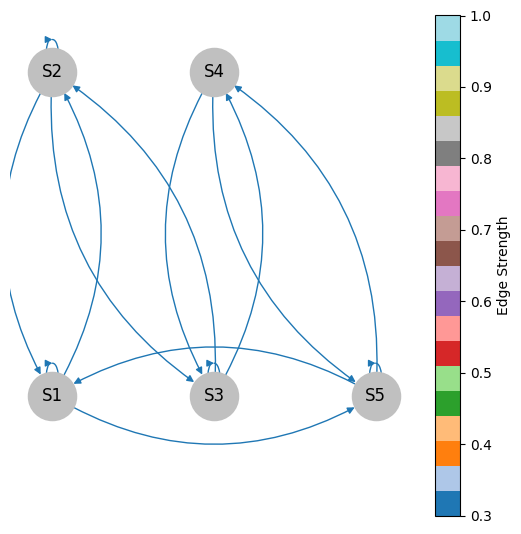

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.figure(figsize=(5, 5))
nx.draw(G_2d_s1, pos_2d_s1,  edge_cmap= plt.cm.tab20,  #cmap = plt.get_cmap('jet'),
        font_size=12, node_size=1200, node_color='#c0c0c0', #[30,30,30,30,30],
        edge_color=weights_2d_s1, with_labels = True, connectionstyle='arc3, rad = 0.3')
#nx.draw_networkx(G, with_labels = True)
plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0.3, 1), cmap=plt.cm.tab20),
              orientation='vertical', label='Edge Strength')
plt.show()

In [ ]:
np.savetxt('proposed-summary-adj-mat.csv', pred_graph_s1, delimiter=",")

In [ ]:
cdt.metrics.SHD(true_graph, pred_graph_s1)

3.0

In [ ]:
true_values = true_graph
predictions = pred_graph_s1

N = true_values.shape[1]*true_values.shape[0]
accuracy = (true_values == predictions).sum() / N
TP = ((predictions == 1) & (true_values == 1)).sum()
FP = ((predictions == 1) & (true_values == 0)).sum()
TN = ((predictions == 0) & (true_values == 0)).sum()
FN = ((predictions == 0) & (true_values == 1)).sum()
precision = TP / (TP+FP)
recall = TP / (TP + FN)
FDR = FP / (FP + TP)
F1 = 2 * (precision * recall) / (precision + recall)
print('Accuracy: {}, Precision: {}, Recall: {}, FDR: {}, F1 Score: {}'.format(accuracy, precision, recall, FDR,F1))

Accuracy: 0.88, Precision: 0.625, Recall: 1.0, FDR: 0.375, F1 Score: 0.7692307692307693
